In [1]:
%matplotlib notebook
import os
import zmq
import numpy as np
import time
import json
import copy
from importlib import reload
from matplotlib import pyplot as plt
from collections import OrderedDict

In [2]:
from plottr import client
reload(client)

<module 'plottr.client' from 'd:\\dropbox\\code\\labpydesktop\\plottr\\plottr\\client.py'>

# Introduction

These are some illustrating examples of how plottr can be used. Basic usage is somewhat simplified by the client class that we import above. 

A few general remarks:
* data coordinates must not be repeated (at the moment that will crash).
* funky coordinates are untested; the measurement expects a nice grid at this point. Should be easy to fix, just needs to be done.

# Send static data

We're sending a bunch of data in a few shapes to illustrate  plottr's basic behavior and UI. We see that we can change the data array being plotted, and we can choose against which axes to plot the data.

In [3]:
def make_1d_data(nx, start=0):
    x = np.linspace(start+0, start+10, nx, dtype=float)
    y = np.cos(x)
    return x, y

def make_2d_data(nx, ny):
    x = np.linspace(0, 10, nx, dtype=float)
    y = np.linspace(-5, 5, ny, dtype=float)
    xx, yy = np.meshgrid(x, y, indexing='ij')
    zz = np.exp(-yy**2/(2 * 2**3)) * np.cos(xx)
    return xx.reshape(-1), yy.reshape(-1), zz.reshape(-1)

def make_2d_avg_data(nx, ny, navg):
    x = np.array([])
    y = np.array([])
    z = np.array([])
    avg = np.array([])
    for i in range(navg):
        _x, _y, _z = make_2d_data(nx, ny)
        _z += (np.random.rand(nx, ny).reshape(-1) * 2. - 1.)
        x = np.append(x, _x)
        y = np.append(y, _y)
        z = np.append(z, _z)
        avg = np.append(avg, np.ones(_z.size) * i)
        
    return x, y, avg, z

In [4]:
# just a boring cos curve
x1, y1 = make_1d_data(21)

# a cos in x and a gauss curve in y
x2, y2, z2 = make_2d_data(31, 11)

# emulate a noise measurement of the cos/gauss data, and average a few times.
x3, y3, avg3, z3 = make_2d_avg_data(31, 11, 10)


sender = client.DataSender(dataId='Dummy data no.1')
sender.addDataSetSimple(sine1d=y1.tolist(), x1=x1.tolist())
sender.addDataSetSimple(cos_gauss=z2.tolist(), osc=x2.tolist(), gauss=y2.tolist())
sender.addDataSetSimple(cos_gauss_avg=z3.tolist(), xvals=x3.tolist(), yvals=y3.tolist(), avg=avg3.tolist())
sender.sendData()

Sending another dataset (i.e., something with a different data ID) will trigger a new data window.

In [ ]:
sender2 = copy.copy(sender)
sender2.data['id'] = 'Dummy data no.2'
sender2.sendData()

# Update data

## Simple 1D case, manual updates

After defining of, each execution of the following cell will add data points to the sine curve.

In [ ]:
of = 0

In [ ]:
# execute this cell manually a few times to see the curve getting longer.
x, y = make_1d_data(21, start=of)
of = x[-1] + (x[-1]-x[-2])

sender = client.DataSender(dataId='Dummy data no.3')
sender.addDataSetSimple(y=y.tolist(), x=x.tolist())
sender.sendData()

## Integrate noisy data

Simple emulation of a measurement that averages (slowly).

In [ ]:
import time
avg = 0

while(avg < 100):
    x, y, _avg, z = make_2d_avg_data(21, 21, 1)
    avgs = (avg * np.ones(z.size)).reshape(-1)
    empty = np.zeros(z.size).reshape(-1)
    
    sender = client.DataSender(dataId='Dummy data no.4')
    sender.addDataSetSimple(z=z, x=x, y=y, avgs=avgs, empty=empty)
    sender.sendData()

    avg += 1
    time.sleep(1)

## Build up 2D data in some silly way

In [ ]:
xvals = []
yvals = []
zvals = []
i = 0
for x in np.linspace(-5, 5, 21):
    for y in np.linspace(-5, 5, 21):
        xvals.append(x)
        yvals.append(y)
        zvals.append(np.exp(-(x**2+y**2)/(2*1.**2)))
        
        i += 1
        if i > 10:
            sender = sender = client.DataSender(dataId='Dummy data no.5')
            sender.addDataSetSimple(z=zvals, x=xvals, y=yvals)
            sender.sendData()
            
            xvals = []
            yvals = []
            zvals = []
            i = 0
            
        time.sleep(0.1)

if len(zvals) > 0:
    sender = sender = client.DataSender(dataId='Dummy data no.5')
    sender.addDataSetSimple(z=zvals, x=xvals, y=yvals)
    sender.sendData()

# QCodes Dataset subscriber

In [5]:
import pytopo # ; reload(pytopo)
from pytopo.qctools import dataset2 as dstools

import plottr # ; reload(plottr)
from plottr.client import DataSender
from plottr.qcodes_dataset import QcodesDatasetSubscriber

In [6]:
import qcodes as qc
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.experiment_container import load_experiment_by_name, new_experiment

def select_experiment(exp_name, sample_name):
    try:
        exp = load_experiment_by_name(exp_name)
    except ValueError:
        exp = new_experiment(exp_name, sample_name)
    return exp

## 1D data

In [11]:
exp = select_experiment('dev: plottr subscriber', 'dummy')
meas = Measurement(exp=exp)
meas.write_period = 0.5

meas.register_custom_parameter('x')
meas.register_custom_parameter('y', setpoints=['x', ])

with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)    
    
    for x in np.linspace(0, 10, 101):
        y = np.cos(x)
        datasaver.add_result(('y', y), ('x', x))
        time.sleep(0.2)

Starting experimental run with id: 16


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


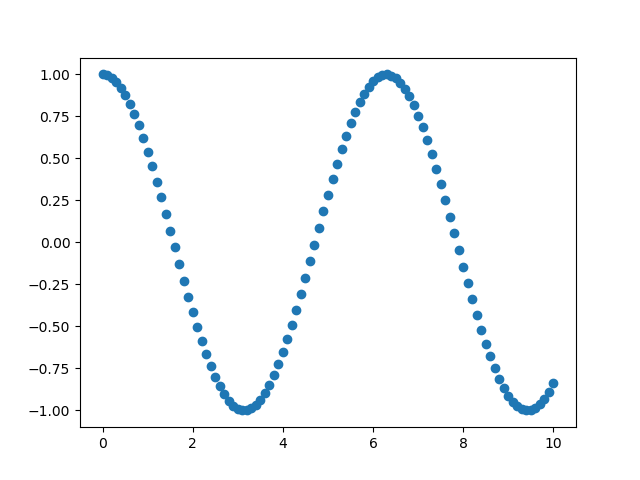

In [12]:
xvals = np.array(datasaver.dataset.get_values('x'))
yvals = np.array(datasaver.dataset.get_values('y'))

fig, ax = plt.subplots(1, 1)
ax.plot(xvals, yvals, 'o')

## 2D data

In [14]:
exp = select_experiment('dev: plottr subscriber (again)', 'dummy 2D!')
meas = Measurement(exp=exp)
meas.write_period = 0.5

meas.register_custom_parameter('x')
meas.register_custom_parameter('y')
meas.register_custom_parameter('z', setpoints=['x', 'y', ])

with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)    
    
    for x in np.linspace(0, 10, 31):
        for y in np.linspace(0, 10, 31):
            z = np.cos(x) * np.sin(y)
            datasaver.add_result(('z', z), ('y', y), ('x', x))
            time.sleep(0.1)

Starting experimental run with id: 11
